In [1]:
import numpy as np
from scipy.stats import beta, norm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pylab
import scipy as sp

# Stable Stochastic Approximation Algorithm

Final differences:  7.32747196253e-15
Final number of iterations:  14055
Last I_n value:  1
Last zeta value:  14054


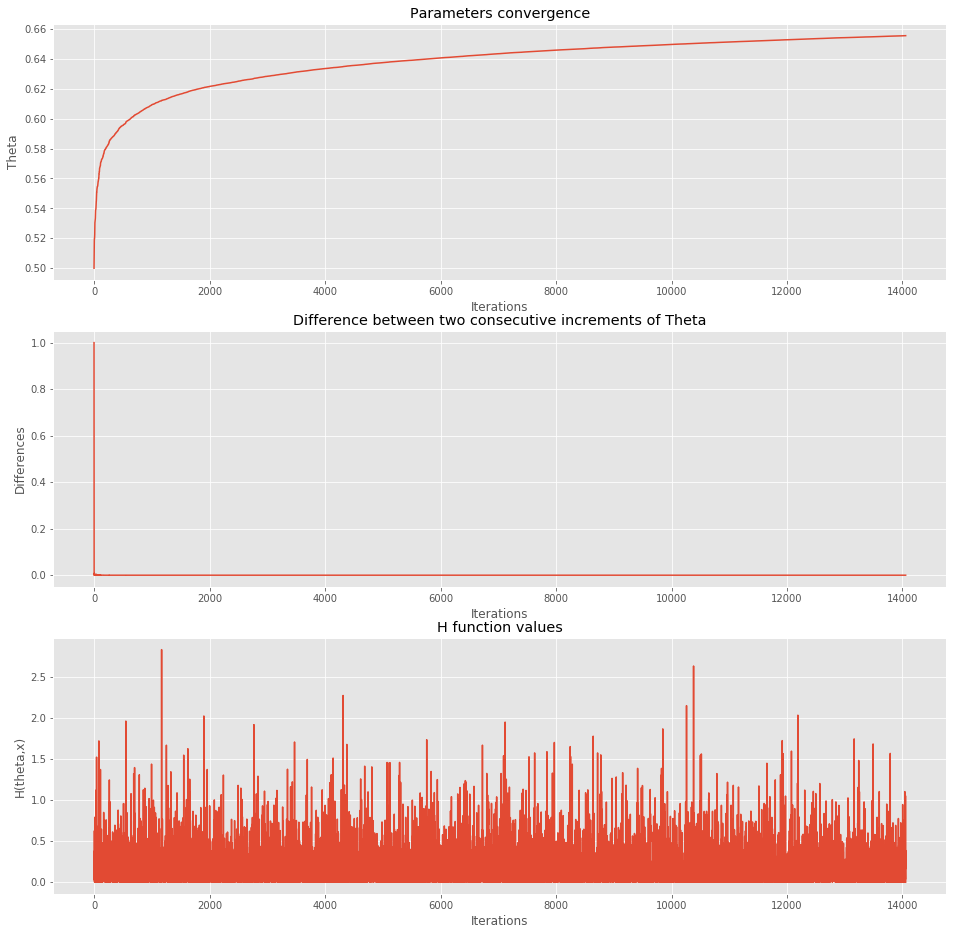

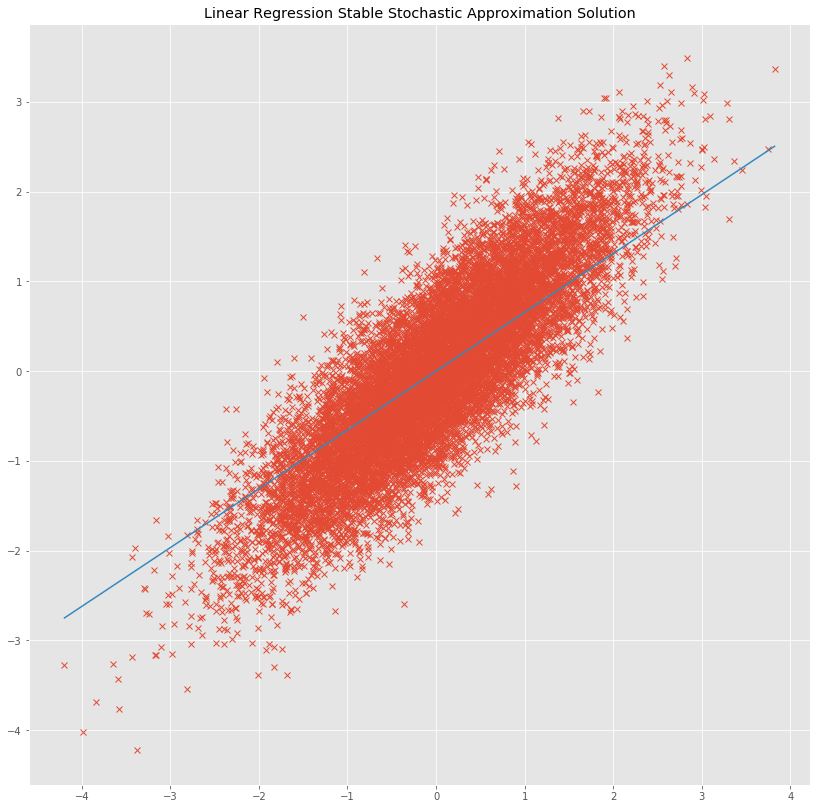

In [27]:
def P(theta, X):
    # In this example, X is an iid sequence with distribution N(mu, sigma) 
    mu = [0, 0]
    sigma = [[1, 0.85], [0.85, 1]]
    return np.random.multivariate_normal(mu, sigma, 1).T
    
def H(theta, X):
    # we will use a mean square error loss in this example
    mse = 1./2. * (X[1]-theta*X[0])**2
    return mse[0]

def K(I):
    return np.array([-I,I])

def is_in(theta, K):
    return theta >= K[0] and theta <= K[1]

def SSA(gamma_0, x, theta, eps=10e-15):
    beta = 0.99
    I = [0]
    n = 0
    zeta = [0]
    diff = 1
    diffs = [diff]
    X_n = [x]
    theta_n = [theta]
    while abs(diff) >= eps:
        if zeta[n] == 0:
            X_tmp = x
            theta_tmp = theta
        else:
            X_tmp = X_n[n]
            theta_tmp = theta_n[n]
        X_next = P(theta_tmp, X_tmp)
        theta_next = theta_tmp + gamma_0/(I[n]+zeta[n]+1+1)**beta * H(theta_tmp, X_next)
        diff = theta_next - theta_n[n]
        diffs.append(diff)
        X_n.append(X_next)
        theta_n.append(theta_next)
        
        if is_in(theta_next, K(I[n])):
            I.append(I[n])
            zeta.append(zeta[n]+1)
        else:
            I.append(I[n]+1)
            zeta.append(0)
        n += 1
    print('Final differences: ', diff)
    print('Final number of iterations: ', n)
    print('Last I_n value: ', I[-1])
    print('Last zeta value: ', zeta[-1])
    return theta_n, X_n, diffs

theta_opt, X, diffs = SSA(0.1, P(0.1, 0), 0.5)

fig, ax = plt.subplots(3,1,figsize=(16,16))
ax[0].plot(range(len(theta_opt)), theta_opt)
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Theta')
ax[0].set_title('Parameters convergence')

ax[1].plot(range(len(diffs)), diffs)
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Differences')
ax[1].set_title('Difference between two consecutive increments of Theta')

ax[2].plot(range(len(theta_opt)), [H(theta_opt[i], X[i]) for i in range(len(theta_opt))])
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('H(theta,x)')
ax[2].set_title('H function values')
plt.show()

def plot_regression(X, theta_opt):
    plt.figure(figsize=(14,14))
    plt.plot(np.array(X)[:,0], np.array(X)[:,1], 'x')
    discr = np.linspace(np.min(np.array(X)[:,0]), np.max(np.array(X)[:,0]), 1000)
    plt.plot(discr, theta_opt*discr)
    plt.title('Linear Regression Stable Stochastic Approximation Solution')
    plt.show()
    
plot_regression(X, theta_opt[-1])

## Example 3.1 - Quantile estimation

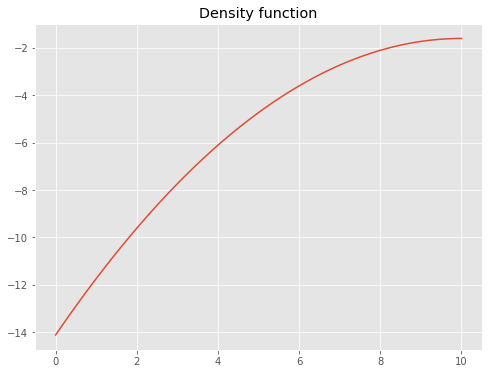

Monte Carlo quantile:  2.68548768838
SA convergence to the quantile:  2.70925227984


In [28]:
# Inputs of SACE algorithm
q = 0.99
d = 2
mu = 10
sigma = 2

def X(mu, sigma):
    return np.random.normal(mu, sigma)

def f(x):
    try:
        return np.log(x)
    except ValueError:
        print("Too small mean value !")

def H(theta, x):
    return q - (f(x)<=theta).astype(float)

def MCquantile(f, X, N=100000):
    values = []
    for i in range(N):
        x = X(mu,sigma)
        values.append(f(x))
    values = np.array(values)
    values = np.sort(values)
    return values[int(q * N)]

def gaussian(x, mu, sigma):
    return 1./np.sqrt(2*np.pi*sigma*sigma) * np.exp(-(x-mu)**2/(2*sigma**2))

def plotdensity(f):
    x = np.linspace(0, 10, 100)
    pylab.figure(figsize=(8,6))
    pylab.plot(x, f(gaussian(x, mu, sigma)))
    pylab.title('Density function')
    pylab.show()
    
plotdensity(f)

# K = [0,5]
P = 0.3

def SA(Klim, x0, theta0):
    x = x0
    theta = theta0
    rho = 0.1
    i = 0
    while theta >= Klim[0] and theta <= Klim[1] and i < 5000:
        i += 1
        rho = 1/(i+1)**0.8
        # Kernel independant de Theta dans cet exemple
        x_next = 0.01 * x + 1 * X(mu,sigma)
        theta = theta + rho * H(theta, x_next)
    return theta

print("Monte Carlo quantile: ", MCquantile(f,X))
print("SA convergence to the quantile: ", SA([0,3], 1, 1))

## Example 3.2 - Stochastic Approximation Cross-Entropy (SACE) algorithm

In [29]:
# Cost of each edge of the graph.
a = np.array([1,2,3,1,2])

# Each sublist of the object 'paths' represents one way to go from the origin to the terminal state.
# The integers denote the edges of the graph taken (following the notation of the paper).
paths = np.array([[0,3],[0,2,4],[1,2,3],[1,4]])

def nu_star(sigma):
    """Return the value of nu that minimizes the Kullback-Leibler divergence 
    of gν from the optimal importance distribution."""
    return(-1 / sigma)

def gibbs_sampler(Y,theta):
    """Gibbs sampling for the SACE."""
    n = np.size(Y)
    Ytilde = np.copy(Y)
    for i in range(n):
        Ytilde[i] = 0
        Y[i] = np.random.uniform(np.max([0,(theta-phi(Ytilde))]),1)
        Ytilde[i] = Y[i]
    return(Y)

def phi(U):
    """Return the shortest path in the graph for weights on edges defined by a and U."""
    minimum = 10000
    cost = 0
    for C in paths:
        cost = np.sum(a[C] * U[C])
        if cost < minimum:
            minimum = cost
    return(minimum)

def p(U):
    """Distribution of the joint variable U=(U_1, ..., U_5)."""
    res = 1
    for u in U:
        if u<0 or u>1:
            res = 0
    return(res)  
    
def sufficient_stat(Y):
    """Sufficient statistic associated with the exponential distribution of the importance sampling distribution."""
    return np.log(Y)    

def beta_product(Z,nu,b=1):
    """Importance sampling distribution gν."""
    n = np.size(Z)
    res = 1
    for i in range(n):
        res *= beta.pdf(Z[i],nu[i],b)
        if (Z[i]<0 or Z[i]>1):
            res = 0
    return(res)

def SACE(quantile):
    n = 5
    Y = np.random.rand(n)
    sigma = sufficient_stat(Y)
    nu = nu_star(sigma)
    theta = phi(Y)
    list_theta = []
    list_nu = []
    T = 500000
    for t in range(T):
        gamma = 0.01 / (t+1)**0.6
        Y = gibbs_sampler(Y,theta)
        Z = np.random.beta(nu,1,n)
        if phi(Z) <= theta:
            theta += gamma * (quantile - p(Z)/beta_product(Z,nu,1))
        else:
            theta += gamma * quantile
        sigma = (1-gamma) * sigma + gamma * sufficient_stat(Y)
        nu = nu_star(sigma)
        list_theta.append(theta)
        list_nu.append(nu)
        
    return(list_theta,list_nu)

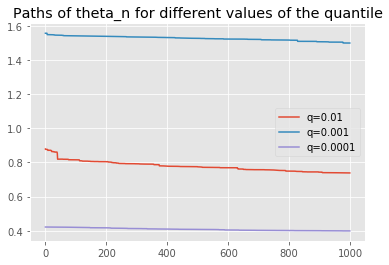

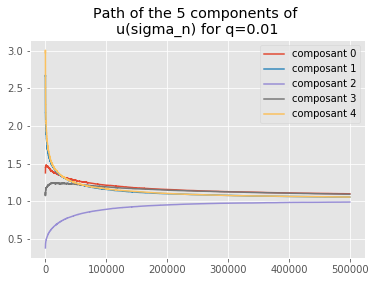

In [31]:
quantiles = [10e-3,10e-4,10e-5]
ls_theta = [[] for i in range(3)]
ls_nu = [[] for i in range(3)]
k = 0
for quantile in quantiles:
    ls_theta[k],ls_nu[k] = SACE(quantile)
    k += 1

plt.figure(1)
for k in range(3):
    plt.plot(ls_theta[k][:1000],label='q='+str(quantiles[k]))
plt.legend()
plt.title('Paths of theta_n for different values of the quantile')
plt.show()

ls_nu = np.array(ls_nu)
plt.figure(2)
for k in range(5):
    plt.plot(ls_nu[0,:,k],label='composant '+str(k))
plt.legend()
plt.title('Path of the 5 components of \nu(sigma_n) for q='+str(quantiles[0]))
plt.show()

## Example 3.3 - Median in multi-dimensional spaces


In [ ]:
# TODO